<a href="https://colab.research.google.com/github/VolkhinD/Houses/blob/main/feature_selection_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  ***Basic Regression Model with Feature Selection Methods***  
========================================================================

# ***Begginning***

In [ ]:
import sys
!{sys.executable} -m pip install xgboost

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error as MSLE, mean_absolute_error
from sklearn.compose import make_column_transformer, make_column_selector as selector
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import make_column_transformer, make_column_selector

Download Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_test = '/content/drive/MyDrive/Data/houses/test.csv'
path_train = '/content/drive/MyDrive/Data/houses/train.csv'

data = pd.read_csv(path_train, index_col=0)
data_lin = pd.read_csv(path_train, index_col=0)
test = pd.read_csv(path_test, index_col=0)
y = data.pop('SalePrice')
data_lin.pop('SalePrice')
print(data.shape, test.shape)

(1460, 79) (1459, 79)


In [ ]:
data.iloc[:5, 62:80]

,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,
1,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
data['BathNum'] = data['FullBath'] + 0.5*data['HalfBath'] + data['BsmtFullBath'] + 0.5*data['BsmtHalfBath']
test['BathNum'] = test['FullBath'] + 0.5*test['HalfBath'] + test['BsmtFullBath'] + 0.5*test['BsmtHalfBath']
data.drop(columns=['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'], inplace=True)
test.drop(columns=['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'], inplace=True)
original_feat = data.columns
num_feat = ['LotFrontage', 'LotArea',  'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'BathNum', 'YrSold']
cat_feat = list(set(data.columns) - set(num_feat))

In [ ]:
data.shape

(1460, 76)

In [ ]:
num_data = data[num_feat]
cat_data = data[cat_feat]
print(f"number of numeric features is {num_data.shape[1]}")
print(f"number of categorical features is {cat_data.shape[1]}")

number of numeric features is 24
number of categorical features is 52


In [ ]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
cat_data = pd.DataFrame(ord_enc.fit_transform(cat_data), columns=cat_feat)
cat_data.shape

(1460, 52)

In [ ]:
data = pd.concat([num_data.reset_index(drop=True), cat_data.reset_index(drop=True)], axis=1)
data.shape

(1460, 76)

# **Imput missing Values**

In [ ]:
data.isnull().sum().sort_values(ascending=False)[:10]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageFinish      81
GarageYrBlt       81
dtype: int64

In [ ]:
data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], inplace=True)

In [ ]:
print(f"New shape is {data.shape}")

New shape is (1460, 70)


## Multivariate feature imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error as mae

## Replace Values for most frequent

In [ ]:
regressor = RandomForestRegressor(random_state=0)
imputer = SimpleImputer(
        missing_values=np.nan, strategy="most_frequent")
data_mode = data[:]
data_knn = data[:]
data_iter = data[:]
def get_scores_for_imputer(imputer, data, y):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, data, y, scoring='neg_root_mean_squared_error', cv=5
    )
    return impute_scores

def get_imputer_mode(data, y):
    imputer = SimpleImputer(
        missing_values=np.nan, strategy="most_frequent")
    mode_scores = get_scores_for_imputer(imputer, data, y)
    return mode_scores.mean(), mode_scores.std()

In [ ]:
res = []
index = []
res += [get_imputer_mode(data_mode, y)]
index += ["Most Frequent"]

## kNN-imputation of the missing values

In [ ]:
def get_imputer_KNN(data, y):
    imputer = KNNImputer(missing_values=np.nan)
    mode_scores = get_scores_for_imputer(imputer, data, y)
    return mode_scores.mean(), mode_scores.std()

res += [get_imputer_KNN(data_knn, y)]
index += ["kNN-imputation "]

## Iterative imputation of the missing values
This uses round-robin linear regression, modeling each feature with missing values as a function of other features, in turn. The version implemented assumes Gaussian (output) variables. If your features are obviously non-normal, consider transforming them to look more normal to potentially improve performance. Our label is not Gaussian, so make it more normal

In [ ]:
def get_impute_iterative(data, y):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    log_y = np.log10(y)
    data = imputer.fit_transform(data, log_y)
    iterative_impute_scores = cross_val_score(
        regressor, data, y, scoring='neg_root_mean_squared_error', cv=5
    )
    return (iterative_impute_scores).mean(), iterative_impute_scores.std()
res += [get_impute_iterative(data_iter, y)]
index += ["Iterative imputation"]

In [ ]:
imput_res = pd.DataFrame(res, index=index, columns=['Mean()', 'STD()'])
imput_res

,Mean(),STD()
Most Frequent,-29433.232746,4005.178243
kNN-imputation,-29533.766860,4048.111423
Iterative imputation,-29298.163073,3644.618856


## Result

In [ ]:
imputer = SimpleImputer(
        missing_values=np.nan, strategy="most_frequent")
imputer.fit(data, y)
data_no_na = imputer.transform(data)
data = pd.DataFrame(data_no_na, columns=data.columns)

In [ ]:
data.isnull().sum()

LotArea         0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
BsmtFinSF1      0
               ..
OverallQual     0
MSZoning        0
GarageType      0
KitchenAbvGr    0
HouseStyle      0
Length: 70, dtype: int64

# **Removing features with low variance**

In [ ]:
print(f"Number of columns has to change since 4 columns represented number of bathrooms transformed to one: shape now {data.shape}")

Number of columns has to change since 4 columns represented number of bathrooms transformed to one: shape now (1460, 70)


Features with a training-set variance lower than this threshold will be removed.

In [ ]:
var_thr = VarianceThreshold(threshold = 0.25)
var_thr.fit(data)

VarianceThreshold(threshold=0.25)

In [ ]:
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True])

OUTPUT:

True: High Variance
False: Low Variance

In [ ]:
data = data[[feat for feat, b in zip(data.columns, var_thr.get_support()) if b]]

Deleted features are

In [ ]:
for feat, b in zip(original_feat, var_thr.get_support()):
  if not b:
    print(feat)

BsmtFinSF2
LowQualFinSF
GrLivArea
GarageYrBlt
GarageArea
GarageCond
OpenPorchSF
Fence


In [ ]:
df = data[:]

# ***Feature Selection***

## **Univariate feature selection**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
def select_and_check(k):
  selector = SelectKBest(f_regression, k=k)
  pipe = make_pipeline(selector, regressor)
  pipe.fit(df, y)
  scores = cross_val_score(
        regressor, df, y, scoring='neg_root_mean_squared_error', cv=5)
  return scores.mean(), scores.std()
res = []
index = []
for k in [25, 40, 35, 60]:
  res += [select_and_check(k)]
  index += [f"{k} features in dataset"]

In [ ]:
imput_res = pd.DataFrame(res, index=index, columns=['Mean()', 'STD()'])
imput_res

,Mean(),STD()
25 features in dataset,-29365.094067,3943.376022
40 features in dataset,-29365.094067,3943.376022
35 features in dataset,-29365.094067,3943.376022
60 features in dataset,-29365.094067,3943.376022


## **Model-based selection**



In [ ]:
curr_features = df.columns
chosen_data = {}

### XGBRegressor

In [ ]:
xgboost = XGBRegressor(random_state=1).fit(df, y)
sfm_xgboost = SelectFromModel(xgboost, max_features=40, prefit=True).fit(df, y)
feat_xg = df.columns[sfm_xgboost.get_support()]
chosen_data["XGBoost Selected"] = df[feat_xg]
print(f"Features selected by SelectFromModel: {feat_xg}")

Features selected by SelectFromModel: Index(['GrLivArea', 'BathNum', 'BsmtQual', 'GarageCars', 'OverallQual'], dtype='object')


In [ ]:
num_chan = make_pipeline(
    SimpleImputer(strategy="mean"), StandardScaler())
cat_chan = make_pipeline(
    SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown="ignore"))
linear_changer = make_column_transformer(
    (num_chan, selector(dtype_include="number")),
    (cat_chan, selector(dtype_include="object")),)
num_data = num_chan.fit_transform(num_data)
data_lin = linear_changer.fit_transform(data_lin)
data_tree = df[:]
num_data = pd.DataFrame(num_data, columns=num_feat)

### Ridge and Lasso Regressions
 >> At forst only with numeracal data than with all data

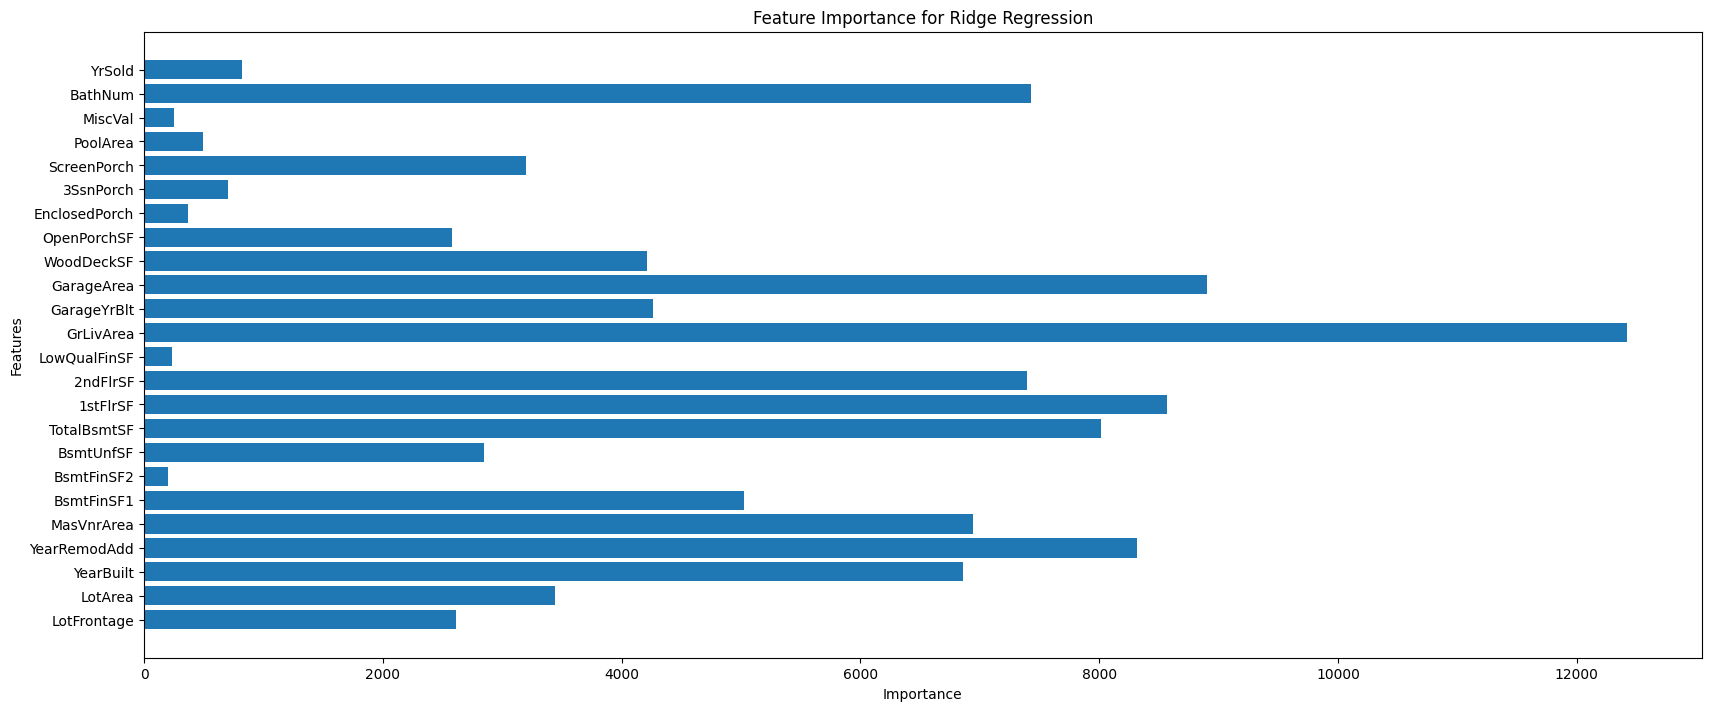

In [ ]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(num_data, y)
importance = np.abs(ridge.coef_)

fig, ax1 = plt.subplots(figsize=(17, 7), layout='constrained')
plt.barh(num_feat, importance)

plt.ylabel("Features")

# setting label of x-axis
plt.xlabel("Importance")
plt.title("Feature Importance for Ridge Regression")
plt.show()

In [ ]:
threshold = np.sort(importance)[-10] + 0.01
sfm = SelectFromModel(ridge, max_features=15).fit(num_data, y)
feat_ridge = [feat for feat, b in zip(num_feat, sfm.get_support()) if b]
print(f"Features selected by SelectFromModel: {feat_ridge}")

Features selected by SelectFromModel: ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'BathNum']


Make Feature Selection for Ridge Regression for Whole Dataset


In [ ]:
import scipy.sparse
data_lin = pd.DataFrame.sparse.from_spmatrix(data_lin)

In [ ]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(data_lin, y)
sfm = SelectFromModel(ridge, max_features=45, prefit=True).fit(data_lin, y)
feature_names = np.array(data_lin.columns)
feat_ridge = [feat for feat, b in zip(data_lin.columns, sfm.get_support()) if b]
chosen_data['Ridge Linear Features'] = data_lin[feat_ridge]

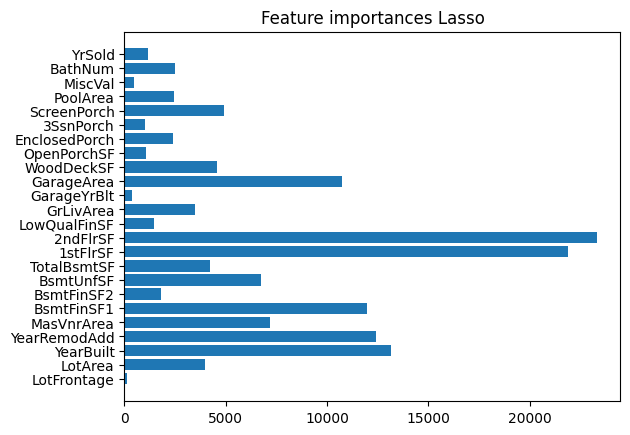

In [ ]:
lasso = Lasso(alpha=2).fit(num_data, y)
importance_l = np.abs(lasso.coef_)
feature_names = np.array(num_feat)
plt.barh(num_feat, importance_l)
plt.title("Feature importances Lasso")
plt.show()

In [ ]:
sfm_lasso = SelectFromModel(lasso, max_features=10, prefit=True).fit(num_data, y)
feat_lasso = feature_names[sfm_lasso.get_support()]
chosen_data["Lasso Linear Features"] = num_data[feat_lasso]
print(f"Features selected by SelectFromModel: {feat_lasso}")

Features selected by SelectFromModel: ['YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtUnfSF'
 '1stFlrSF' '2ndFlrSF' 'GarageArea' 'WoodDeckSF' 'ScreenPorch']


<BarContainer object of 62 artists>

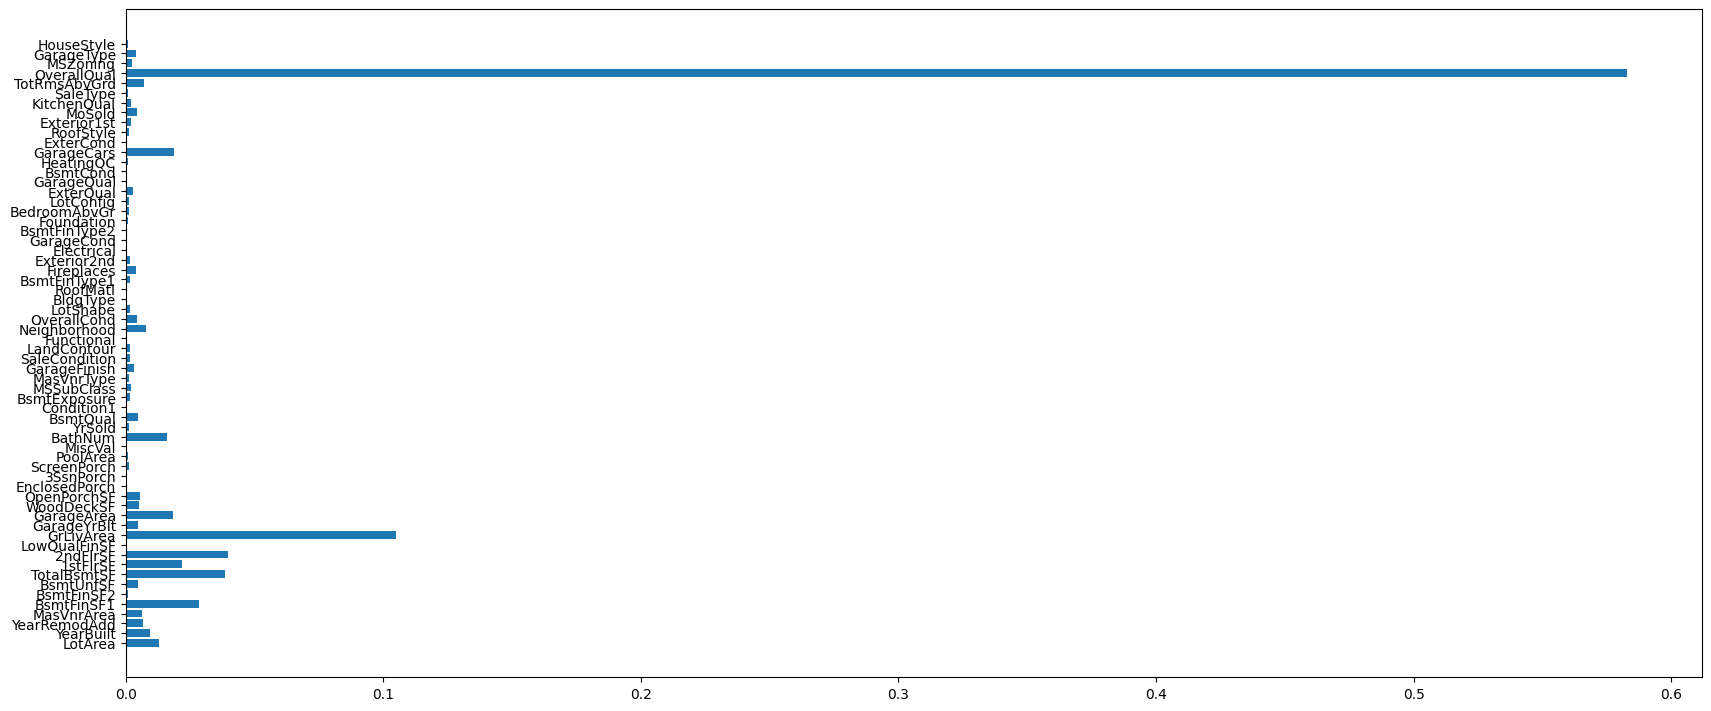

In [ ]:
forest = RandomForestRegressor(n_estimators=100, random_state=16)
forest.fit(df, y)
fig, ax = plt.subplots(figsize=(17, 7), layout='constrained')
plt.barh(curr_features, forest.feature_importances_ )

In [ ]:
sfm_tree = SelectFromModel(forest, max_features=30).fit(df, y)
feat_tree = curr_features[sfm_tree.get_support()]
chosen_data["Random Forest Tree Features"] = df[feat_tree]
print(f"Features selected by SelectFromModel for random Forest: {feat_tree}")

Features selected by SelectFromModel for random Forest: Index(['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'GarageArea', 'GarageCars', 'OverallQual'],
      dtype='object')


## **Iterative selection, with Sequential Feature Selection**
\
There is one more implementation of this algorithm "backward" but it require more that 5 hours to complete.  


In [ ]:
%%time
sfs_forward_ridge = SequentialFeatureSelector(ridge, n_features_to_select=50, direction="forward").fit(data_lin, y)



CPU times: user 3h 7min 46s, sys: 1h 10min 59s, total: 4h 18min 46s
Wall time: 3h 12min 47s


In [ ]:
%%time
sfs_forward_tree = SequentialFeatureSelector(AdaBoostRegressor(), n_features_to_select=30, direction="forward").fit(data_tree, y)


CPU times: user 17min 35s, sys: 2.73 s, total: 17min 37s
Wall time: 17min 48s


In [ ]:
%%capture
sfs_forward_xgb = SequentialFeatureSelector(XGBRegressor(random_state=1), n_features_to_select=30, direction="forward").fit(data_tree, y)

In [ ]:
%%capture
sfs_backward_xgb = SequentialFeatureSelector(XGBRegressor(random_state=1),
                                             n_features_to_select=30, direction="backward").fit(data_tree, y)

In [ ]:
feat_sfs_forward_ridge = data_lin.columns[sfs_forward_ridge.get_support()]
feat_sfs_forward_tree = data_tree.columns[sfs_forward_tree.get_support()]

feat_sfs_forward_xgb = data_tree.columns[sfs_forward_xgb.get_support()]
feat_sfs_backward_xgb = data_tree.columns[sfs_backward_xgb.get_support()]

In [ ]:
path = '/content/drive/MyDrive/Data/houses/'
data_lin[feat_sfs_forward_ridge].to_csv(path + 'sfs_forward_linear.csv')
data_tree[feat_sfs_forward_tree].to_csv(path + 'sfs_forward_tree.csv')

data_tree[feat_sfs_forward_xgb].to_csv(path + 'sfs_forward_xgb.csv')
data_tree[feat_sfs_backward_xgb].to_csv(path + 'sfs_backward_xgb.csv')


<ipython-input-47-9cc5546fb191>:2: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  data_lin[feat_sfs_forward_ridge].to_csv(path + 'sfs_forward_linear.csv')


In [ ]:
chosen_data["SFS forward Linear"] = pd.read_csv(path + 'sfs_forward_linear.csv')
chosen_data["SFS forward Tree"] = pd.read_csv(path + 'sfs_forward_tree.csv')

chosen_data["SFS forward XGB"] = pd.read_csv(path + 'sfs_forward_xgb.csv')
chosen_data["SFS backward XGB"] = pd.read_csv(path + 'sfs_backward_xgb.csv')


## **Iterative selection, Recursive Feature Elimination, RFE**


In [ ]:
%%time
selector = RFE(RandomForestRegressor(n_estimators=100, random_state=32), n_features_to_select=30).fit(data_tree, y)
data_rfe_forest = pd.DataFrame(selector.transform(data_tree))
chosen_data["RFE Random Forest Tree"] = data_rfe_forest


selector2 = RFE(ridge, n_features_to_select=100).fit(data_lin, y)
data_rfe_lin = selector2.transform(data_lin)
chosen_data["RFE Linear Regression"] = data_rfe_lin

selector3 = RFE(XGBRegressor(random_state=1),n_features_to_select=30).fit(data_tree, y)
data_rfe_xgb = pd.DataFrame(selector3.transform(data_tree))
chosen_data["RFE XGBoost"] = data_rfe_xgb


CPU times: user 2min 28s, sys: 32.5 s, total: 3min 1s
Wall time: 2min 18s


# ***Models with new Data***

In [ ]:
scores = {'neg_mean_absolute_error': []}
index = []

## **Cartesian Product for All Models and All Data**

In [ ]:
for name, data in chosen_data.items():
  if 'Linear' in name:
    result = cross_val_score(Lasso(), X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + Lasso']
    scores['neg_mean_absolute_error'].append(result.mean())
    result = cross_val_score(RidgeCV(alphas=np.logspace(-6, 6, num=5)), X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + Ridge']
    scores['neg_mean_absolute_error'].append(result.mean())
    result = cross_val_score(XGBRegressor(random_state=1), X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + XGBRegressor']
    scores['neg_mean_absolute_error'].append(result.mean())

  else:
    result = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=1), X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + Random Forest']
    scores['neg_mean_absolute_error'].append(result.mean())
    result = cross_val_score(XGBRegressor(random_state=1), X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + XGBRegressor']
    scores['neg_mean_absolute_error'].append(result.mean())
result = cross_val_score(RidgeCV(alphas=np.logspace(-6, 6, num=5)), X=data_lin, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + Ridge']
scores['neg_mean_absolute_error'].append(result.mean())
result = cross_val_score(Lasso(), X=data_lin, y=y, cv=5, scoring='neg_mean_absolute_error')
index += [name + ' + Lasso']
scores['neg_mean_absolute_error'].append(result.mean())
result = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=1), X=data_tree, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + Random Forest']
scores['neg_mean_absolute_error'].append(result.mean())
result = cross_val_score(XGBRegressor(random_state=1), X=data_tree, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + XGBRegressor']
scores['neg_mean_absolute_error'].append(result.mean())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8030274433.741394, tolerance: 759214014.2531197
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9052021858.529907, tolerance: 699031751.5199751
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4971085522.226074, tolerance: 724930391.3116124
  model = cd_fast.sparse_enet_coordinate_descent(


In [ ]:
df_scores = pd.DataFrame(scores, index=index)
df_scores

,neg_mean_absolute_error
XGBoost Selected + Random Forest,-2.315091e+04
XGBoost Selected + XGBRegressor,-2.347348e+04
Ridge Linear Features + Lasso,-2.802637e+04
Ridge Linear Features + Ridge,-2.770821e+04
Ridge Linear Features + XGBRegressor,-2.841026e+04
Lasso Linear Features + Lasso,-2.504466e+04
Lasso Linear Features + Ridge,-2.504289e+04
Lasso Linear Features + XGBRegressor,-2.254602e+04
Random Forest Tree Features + Random Forest,-1.991134e+04
Random Forest Tree Features + XGBRegressor,-2.105795e+04


The best estimator is XGBoost

## **PCA + Models**

In [ ]:
scores = {'neg_mean_absolute_error': []}
index = []
n_comp = [50, 75, 100, 125, 150]
for n in n_comp:
  pca = PCA(n_components=n)
  data_pca = pca.fit_transform(data_lin.to_numpy())
  model = XGBRegressor(random_state=1)
  result = cross_val_score(model, X=data_pca, y=y, cv=5, scoring='neg_mean_absolute_error')
  index += [f'PCA with {n} components + XGBRegressor Linear ']
  scores['neg_mean_absolute_error'].append(result.mean())


In [ ]:
df_scores = pd.DataFrame(scores, index=index)
df_scores

,neg_mean_absolute_error
PCA with 50 components + XGBRegressor Linear,-17734.697533
PCA with 75 components + XGBRegressor Linear,-17532.136681
PCA with 100 components + XGBRegressor Linear,-17976.696995
PCA with 125 components + XGBRegressor Linear,-17773.419020
PCA with 150 components + XGBRegressor Linear,-17517.884833


## **Best Models**

In [ ]:
scores = {'neg_mean_absolute_error': []}
index = []
for name, data in chosen_data.items():
    result = cross_val_score(XGBRegressor(random_state=1), X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + XGBRegressor']
    scores['neg_mean_absolute_error'].append(result.mean())

result = cross_val_score(XGBRegressor(random_state=1), X=data_tree, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + XGBRegressor Tree']
scores['neg_mean_absolute_error'].append(result.mean())
result = cross_val_score(XGBRegressor(random_state=1), X=data_lin, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + XGBRegressor Linear']
scores['neg_mean_absolute_error'].append(result.mean())


In [ ]:
df_scores = pd.DataFrame(scores, index=index)
df_scores

,neg_mean_absolute_error
XGBoost Selected + XGBRegressor,-23473.476627
Ridge Linear Features + XGBRegressor,-28410.255693
Lasso Linear Features + XGBRegressor,-22546.022367
Random Forest Tree Features + XGBRegressor,-21057.953548
SFS forward Linear + XGBRegressor,-17475.175356
SFS forward Tree + XGBRegressor,-18371.885111
SFS forward XGB + XGBRegressor,-18794.543359
SFS backward XGB + XGBRegressor,-17294.372996
RFE Random Forest Tree + XGBRegressor,-17447.945528
RFE Linear Regression + XGBRegressor,-17452.057291


## **Grid Search for Best Model Linear Data**

In [ ]:
%%time
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5],
                        "min_child_weight": [ 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4]},
            cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
gsc.fit(data_lin, y)

In [ ]:
best_model = XGBRegressor(gsc.best_params_)
scores = {'neg_mean_absolute_error': []}
index = []
for name, data in chosen_data.items():
    result = cross_val_score(best_model, X=data, y=y, cv=5, scoring='neg_mean_absolute_error')
    index += [name + ' + XGBRegressor']
    scores['neg_mean_absolute_error'].append(result.mean())

result = cross_val_score(best_model, X=data_tree, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + XGBRegressor Tree']
scores['neg_mean_absolute_error'].append(result.mean())
result = cross_val_score(XGBRegressor(random_state=1), X=data_lin, y=y, cv=5, scoring='neg_mean_absolute_error')
index += ['Full Data + XGBRegressor Linear']
scores['neg_mean_absolute_error'].append(result.mean())


In [ ]:
df_scores = pd.DataFrame(scores, index=index)
df_scores

,neg_mean_absolute_error
XGBoost Selected + XGBRegressor,-22849.526833
Ridge Linear Features + XGBRegressor,-26617.004679
Lasso Linear Features + XGBRegressor,-21640.067953
Random Forest Tree Features + XGBRegressor,-20386.850734
SFS forward Linear + XGBRegressor,-15876.519010
SFS forward Tree + XGBRegressor,-16533.043595
SFS forward XGB + XGBRegressor,-16984.823285
SFS backward XGB + XGBRegressor,-16433.498242
RFE Random Forest Tree + XGBRegressor,-16096.947434
RFE Linear Regression + XGBRegressor,-16059.611507
